# MAHTS generation

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***

To do:

* Fix extra pixel on edge of interpolated raster
* Fill gaps with 3 year composite


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_spatialtools import interpolate_2d


def get_geopoly(index, gdf):
    '''
    Selects a row from a geopandas.GeoDataFrame, and converts this
    into a geopolygon feature as an input to dc.load
    '''
    return Geometry(geo=gdf.loc[index].geometry.__geo_interface__, 
                    crs=CRS(gdf.crs['init']))


def interpolate_tide(timestep_ds, tidepoints_gdf, method='rbf', factor=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''    
  
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:19].replace('T', ' ')
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    print(time_string, end='\r')
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              method=method,
                              factor=factor)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def load_tidal_subset(year_ds, tide_cutoff):
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}')
    
    # Determine what pixels were acquired above median tide, and drop
    # time-steps without any pixels above median tide to reduce data to load
    high_tide_bool = year_ds.tide_m >= tide_cutoff
    year_ds = year_ds.sel(time=high_tide_bool.sum(dim=['x', 'y']) > 0)
    
    # Apply mask, and load in corresponding high tide data
    year_ds = year_ds.where(high_tide_bool)
    return year_ds.compute()

    
def tidal_composite(year_ds, 
                    label, 
                    label_dim, 
                    output_dir, 
                    output_prefix='',
                    export_geotiff=False):
    '''
    Loads data for a time period into memory, masks to keep only
    pixels observed at > median tide, takes median and counts of valid 
    water index results, and optionally writes each water index, tide 
    height and valid pixel counts for the time period to file
    '''
        
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    median_ds['stdev'] = year_ds.mndwi.std(dim='time', keep_attrs=True)
    
    # Write each variable to file  
    if export_geotiff:
        for i in median_ds:
            try:
                
                # Write using float nodata type
                geotiff_profile = {'blockxsize': 1024, 
                                       'blockysize': 1024, 
                                       'compress': 'deflate', 
                                       'zlevel': 5,
                                       'nodata': np.nan}
                
                write_geotiff(filename=f'{output_dir}/{output_prefix}{i}_{str(label)}.tif', 
                              dataset=median_ds[[i]],
                              profile_override=geotiff_profile)
            except:
                
                # Update nodata value for int data type
                geotiff_profile.update(nodata=-999)
                write_geotiff(filename=f'{output_dir}/{output_prefix}{i}_{str(label)}.tif', 
                              dataset=median_ds[[i]],
                              profile_override=geotiff_profile)
            
    # Set coordinate and dim
    median_ds = (median_ds
                 .assign_coords(**{label_dim: label})
                 .expand_dims(label_dim)) 
        
    return median_ds


### Set up Dask

In [2]:
from datacube.utils.rio import configure_s3_access
from datacube.utils.dask import start_local_dask
import os
import dask
from dask.utils import parse_bytes

# configure dashboard link to go over proxy
dask.config.set({"distributed.dashboard.link":
                 os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# Figure out how much memory/cpu we really have (those are set by jupyterhub)
mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4
mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')

# leave 4Gb for notebook itself
mem_limit -= parse_bytes('4Gb')

# close previous client if any, so that one can re-run this cell without issues
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = start_local_dask(n_workers=1,
                          threads_per_worker=cpu_limit, 
                          memory_limit=mem_limit)
display(client)

# Configure GDAL for s3 access 
configure_s3_access(aws_unsigned=True,  # works only when reading public resources
                    client=client);

Client Scheduler: tcp://127.0.0.1:33025 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 60.42 GB


### Connect to the datacube

In [3]:
# dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [4]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [5]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')
comp_gdf = gpd.read_file('input_data/Euc_SCC_coast10kmbuffer.geojson').set_index('ID_Seconda')

In [6]:
study_area = 'WA13.01'
query = {'geopolygon': get_geopoly(study_area, comp_gdf),
         'time': ('1987', '2019'),
         'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}

# Preview study area
display_map(x=(query['geopolygon'].envelope.left, 
               query['geopolygon'].envelope.right), 
            y=(query['geopolygon'].envelope.top, 
               query['geopolygon'].envelope.bottom))


## Load virtual product

In [7]:
# product = catalog['ls_nbart_indices']
# ds = product.load(dc, **query)
# ds

from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

ds = load_ard(dc=dc, 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.0,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              output_crs='epsg:32750',
              resampling={'*': 'average', 'fmask': 'nearest', 'oa_fmask': 'nearest'},
              resolution=(-30, 30),  
              gqa_iterative_mean_xy=[0, 1],
              align=(15, 15),
              lazy_load=True,
              group_by='solar_day',
              **query)

ds = (calculate_indices(ds, index=['NDWI', 'MNDWI', 'AWEI_ns', 'AWEI_sh'], 
                        collection='ga_ls_3', 
                        drop=True)
      .rename({'NDWI': 'ndwi', 'MNDWI': 'mndwi', 'AWEI_ns': 'awei_ns', 'AWEI_sh': 'awei_sh'}))

# Mask to study area
from rasterio.features import rasterize
estuary_mask = rasterize(shapes=comp_gdf.to_crs({'init': str(ds.crs)}).loc[study_area]['geometry'],
                         out_shape=ds.mndwi.shape[1:],
                         transform=ds.geobox.transform,
                         all_touched=True).astype(bool)

ds = ds.where(estuary_mask)


Loading ga_ls5t_ard_3 data
    659 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    728 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    258 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 1645 observations as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


## Model tides

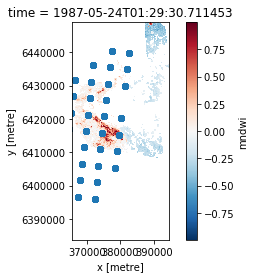

In [8]:
# Pull out subset of modelling points for region around satellite data
try:
    bounds = comp_gdf.loc[study_area].geometry.buffer(0.05)
except:
    bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.05).wkt)
    
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=0).mndwi.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [9]:
# Interpolate tides for each timestep into the spatial extent of the data
tide_da = ds.groupby('time').apply(interpolate_tide, 
                                   tidepoints_gdf=tidepoints_gdf,
                                   factor=50)

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add interpolated tides as measurement in satellite dataset
ds['tide_m'] = tide_da

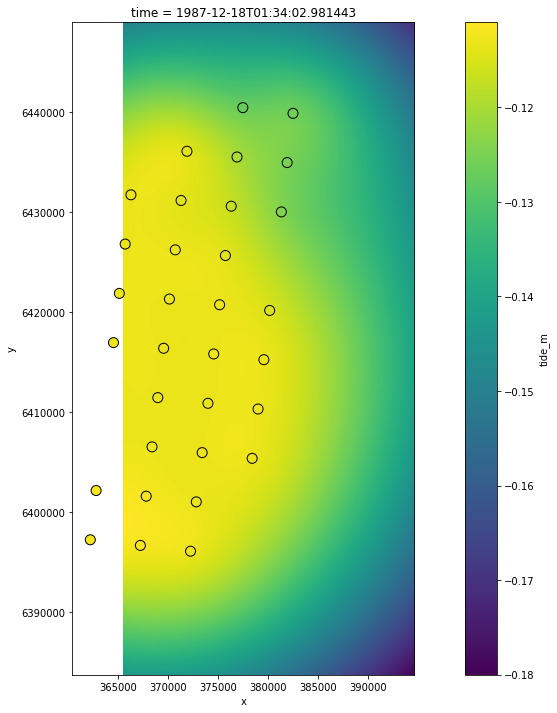

In [10]:
# Plot 
ds_i = ds['tide_m'].isel(time=10)
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(), 
                                                     vmax=ds_i.max().item())

## Generate yearly composites

In [11]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{study_area}'
os.makedirs(output_dir, exist_ok=True)

# Create empty vars containing un-composited data from the previous,
# current and future year. This is progressively updated to ensure that
# no more than 3 years of data are loaded into memory at any one time
previous_ds = None
current_ds = None
future_ds = None

# Iterate through each year in the dataset, starting at one year before
for year in np.unique(ds.time.dt.year) - 1:
    
    # Load data for the subsequent year
    future_ds = load_tidal_subset(ds.sel(time=str(year + 1)), 
                                  tide_cutoff=tide_cutoff)
    
    # If the current year var contains data, combine these observations
    # into median annual high tide composites and export GeoTIFFs
    if current_ds:
        
        # Generate composite
        tidal_composite(current_ds, 
                        label=year,
                        label_dim='year',
                        output_dir=output_dir, 
                        export_geotiff=True)        
        
    # If ALL of the previous, current and future year vars contain data,
    # combine these three years of observations into a single median 
    # 3-year gapfill composite
    if previous_ds and current_ds and future_ds:
        
        # Concatenate the three years into one xarray.Dataset
        gapfill_ds = xr.concat([previous_ds, current_ds, future_ds], 
                               dim='time')
        
        # Generate composite
        tidal_composite(gapfill_ds,
                        label=year,
                        label_dim='year',
                        output_dir=output_dir, 
                        output_prefix='gapfill_',
                        export_geotiff=True)        
    
    # Shift all loaded data back so that we can re-use it in the next
    # iteration and not have to load the same data multiple times
    previous_ds = current_ds
    current_ds = future_ds
    future_ds = []


Processing 1987
Processing 1988


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1989


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1990


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1991


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1992


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1993


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1994


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1995


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1996


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1997


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1998


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 1999


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2000


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2001


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2002


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2003


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2004


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2005


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2006


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2007


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2008


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2009


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2010


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2011


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2012


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2013


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2014


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2015


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2016


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2017


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2018


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2019


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.7+138.g59cc64f9.dirty
